In [39]:
import cv2, os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [40]:
cascadelocation = "haarcascade_frontalface_default.xml"
facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [41]:
def prepare_dataset(directory):
    paths = [os.path.join(directory, filename) for filename in os.listdir(directory)]
    images = []
    labels = []
    row = 140
    col = 140
    for image_path in paths:
        image_pil = Image.open(image_path).convert('L')
        image = np.array(image_pil, 'uint8')
        nbr = int(os.path.split(image_path)[1].split('.')[0].replace("subject", ""))
        faces = facecascade.detectMultiScale(image)
        for (x,y,w,h) in faces:
            images.append(image[y:y+col, x:x+row])
            labels.append(nbr)
            cv2.imshow("Reading Faces", image[y:y+col, x:x+row])
            cv2.waitKey(50)
            cv2.destroyAllWindows()
    return images, labels, row, col

In [42]:
directory = 'yalefaces'
images, labels, row, col = prepare_dataset(directory)
cv2.destroyAllWindows

<function destroyAllWindows>

In [43]:
len(images)

166

In [44]:
image_data = []
for i in range(len(images)):
    image_data.append(images[i].flatten())
print(len(image_data[0]))
image_mat = np.matrix(image_data)
image_mat.shape

19600


(166, 19600)

In [45]:
mean_img = np.mean(image_mat, axis=0)
print("Mean Matrix Shape: ", mean_img.shape)
image_conv = np.cov(image_mat)
print("Image Convolution Matrix Shape: ", image_conv.shape)
eigen_val, eigen_vec = np.linalg.eig(image_conv)

Mean Matrix Shape:  (1, 19600)
Image Convolution Matrix Shape:  (166, 166)


In [46]:
eigen_vec[0].shape

(166,)

In [47]:
eigen_vecs = []
for i in range(eigen_vec.shape[1]):
    eig1 = image_mat.T@eigen_vec[:,i]
    eig1 = eig1/eigen_val[i]
    eigen_vecs.append(np.ravel(eig1))
print("The transformed eigen vectors matrix size :", np.matrix(eigen_vecs).shape)

The transformed eigen vectors matrix size : (166, 19600)


In [48]:
sort_ind = np.argsort(eigen_val)
sort_ind = sort_ind[::-1]

eig_val_sum = np.sum(eigen_val)

temp_sum = 0
principal_eig_vec = []
principal_eig_val = []
i = 0
while(temp_sum < 0.98*eig_val_sum):
    principal_eig_vec.append(eigen_vecs[sort_ind[i]])
    principal_eig_val.append(eigen_val[sort_ind[i]])
    temp_sum += eigen_val[sort_ind[i]]
    i+=1
print("Number of components is {}".format(i))

Number of components is 83


In [49]:
Q_hat = np.matrix(principal_eig_vec)
print(Q_hat.shape)

(83, 19600)


In [50]:
trans_image_data = image_mat@Q_hat.T
print(trans_image_data.shape)

(166, 83)


In [57]:
trans_image_data

matrix([[ -9481.49094887+0.j,   4674.94867316+0.j,   6476.00972239+0.j,
         ..., 110284.01593171+0.j, 143417.07925016+0.j,
          30330.16503079+0.j],
        [-12233.76571345+0.j,   5736.01697271+0.j,   7176.92591189+0.j,
         ..., 138570.09782527+0.j, 178969.34146122+0.j,
          35744.4665019 +0.j],
        [-12233.76571345+0.j,   5736.01697271+0.j,   7176.92591189+0.j,
         ..., 138570.09782527+0.j, 178969.34146122+0.j,
          35744.4665019 +0.j],
        ...,
        [-11648.41912084+0.j,   3854.34006365+0.j,   5688.09977554+0.j,
         ..., 125599.53110988+0.j, 159782.48513944+0.j,
          34622.56585418+0.j],
        [-10593.57193608+0.j,   3726.55470738+0.j,   5298.59149655+0.j,
         ..., 110692.36090775+0.j, 144107.40076804+0.j,
          30408.67429491+0.j],
        [-10820.49724057+0.j,   4127.02922598+0.j,   4078.19035735+0.j,
         ..., 110240.36049092+0.j, 151044.77058073+0.j,
          31305.30790975+0.j]])

In [59]:
trans_image_data=trans_image_data.real

In [62]:
trans_image_data

matrix([[ -9481.49094887,   4674.94867316,   6476.00972239, ...,
         110284.01593171, 143417.07925016,  30330.16503079],
        [-12233.76571345,   5736.01697271,   7176.92591189, ...,
         138570.09782527, 178969.34146122,  35744.4665019 ],
        [-12233.76571345,   5736.01697271,   7176.92591189, ...,
         138570.09782527, 178969.34146122,  35744.4665019 ],
        ...,
        [-11648.41912084,   3854.34006365,   5688.09977554, ...,
         125599.53110988, 159782.48513944,  34622.56585418],
        [-10593.57193608,   3726.55470738,   5298.59149655, ...,
         110692.36090775, 144107.40076804,  30408.67429491],
        [-10820.49724057,   4127.02922598,   4078.19035735, ...,
         110240.36049092, 151044.77058073,  31305.30790975]])

In [63]:
trans_image_data.shape

(166, 83)

In [60]:
from sklearn.neighbors import BallTree

In [61]:
face_tree = BallTree(trans_image_data, leaf_size = 15)

In [72]:
test_img = trans_image_data[1:2,:]
test_img.shape

(1, 83)

In [73]:
f_dist, f_ind = face_tree.query(np.asarray(test_img), k=10)

In [74]:
f_ind

array([[ 1,  2, 56,  9,  5,  6, 10,  8, 11, 12]], dtype=int64)

In [75]:
f_dist

array([[    0.        ,     0.        , 18638.87599507, 19752.84248421,
        19891.85428494, 19900.22801594, 23157.35033651, 24056.68825821,
        27293.8301216 , 36647.89677826]])

In [76]:
for i, ind in enumerate(f_ind[0]):
    cv2.imshow("result", images[ind])
    if cv2.waitKey(0) == 'q':
        cv2.destroyAllWindows
cv2.destroyAllWindows

<function destroyAllWindows>

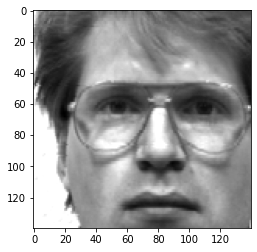

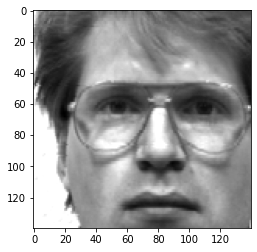

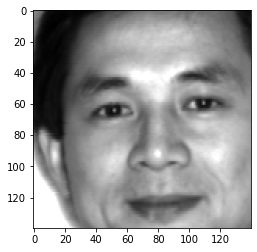

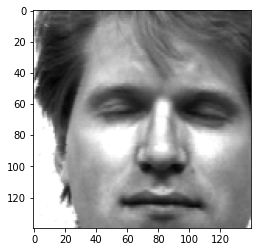

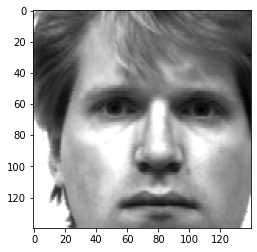

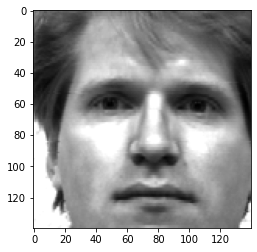

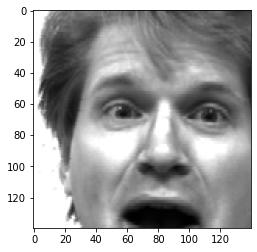

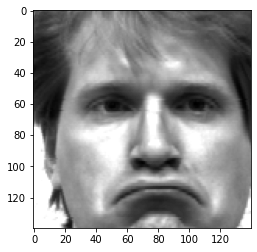

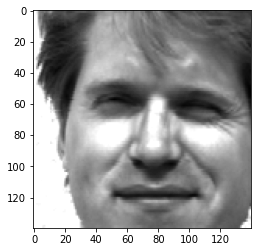

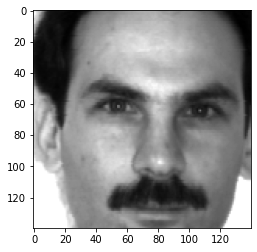

In [77]:
fig = plt.figure()
cols = 2
for n in f_ind[0]:
    plt.subplot()
    plt.gray()
    plt.imshow(images[n])
    plt.show()
plt.show()